``plot_trace``関数でワーニングを出さないため次のコマンド実行が必要です。

In [1]:
#!pip install --upgrade numba | tail -n 1

## 4章　はじめてのベイズ推論実習

<a href="https://colab.research.google.com/github/makaishi2/python_bayes_intro/blob/main/notebooks/4%E7%AB%A0_%E3%81%AF%E3%81%98%E3%82%81%E3%81%A6%E3%81%AE%E3%83%99%E3%82%A4%E3%82%BA%E6%8E%A8%E8%AB%96%E5%AE%9F%E7%BF%92.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 共通処理

In [2]:
#%matplotlib inline
# 日本語化ライブラリ導入
#!pip install japanize-matplotlib | tail -n 1

In [3]:
# ライブラリのimport

# NumPy用ライブラリ
import numpy as np
# Matplotlib中のpyplotライブラリのインポート
import matplotlib.pyplot as plt
# matplotlib日本語化対応ライブラリのインポート
import japanize_matplotlib
# pandas用ライブラリ
import pandas as pd
# データフレーム表示用関数
from IPython.display import display
# seaborn
import seaborn as sns
# 表示オプション調整
# NumPy表示形式の設定
np.set_printoptions(precision=3, floatmode='fixed')
# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14
# サイズ設定
plt.rcParams['figure.figsize'] = (6, 6)
# 方眼表示ON
plt.rcParams['axes.grid'] = True
# データフレームでの表示精度
pd.options.display.float_format = '{:.3f}'.format
# データフレームですべての項目を表示
pd.set_option("display.max_columns",None)

In [4]:
import pymc as pm
import arviz as az

print(f"Running on PyMC v{pm.__version__}")
print(f"Running on ArViz v{az.__version__}")

Running on PyMC v5.11.0
Running on ArViz v0.17.1


### 問題定義
常に確率が一定で、前回の結果が次回に一切影響しない(数学的には「独立な事象」という)くじ引きがあります。  
ある人がこのくじ引きを5回引いたところ、結果は「当たり、はずれ、はずれ、当たり、はずれ」でした。  
一回のくじ引きにあたる確率を $p$ とするとき、この $p$ の値を求めなさい。

### 4.2 最尤推定

####  尤度関数のグラフ

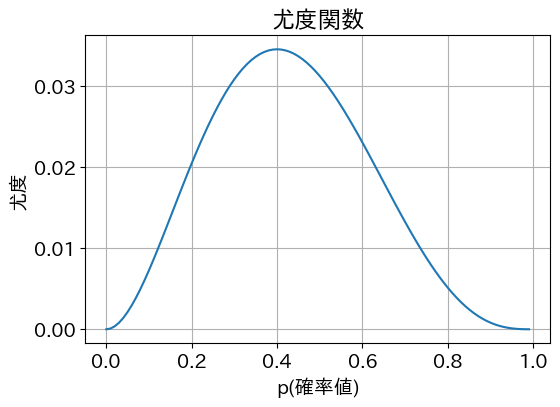

In [5]:
def lh(p):
    return p ** 2 * (1-p) ** 3

# グラフ描画用x座標の定義
# 0.0 < x < 1.0
p = np.arange(0.0, 1.0, 0.01)

# グラフ描画
plt.rcParams['figure.figsize'] = (6, 4)
plt.plot(p, lh(p))
plt.xlabel('p(確率値)')
plt.ylabel('尤度')
plt.title(f'尤度関数');

#### PyTorchで解く

In [6]:
import torch # ライブラリインポート

def log_lh(p): # 対数尤度関数
    return (2 * torch.log(p) + 3 * torch.log(1-p))

num_epochs = 40 # 繰り返し回数
lr = 0.01           # 学習率

# パラメータ初期値 (p=0.1)
p = torch.tensor(0.1, dtype=torch.float32, requires_grad=True)

logs = np.zeros((0,3))
for epoch in range(num_epochs):
    loss = -log_lh(p)       # 損失計算
    loss.backward()         # 勾配計算
    with torch.no_grad():
        p -= lr * p.grad    # パラメータ修正
        p.grad.zero_()      # 勾配値の初期化
    log = np.array([epoch, p.item(), loss.item()]).reshape(1,-1)
    logs = np.vstack([logs, log])

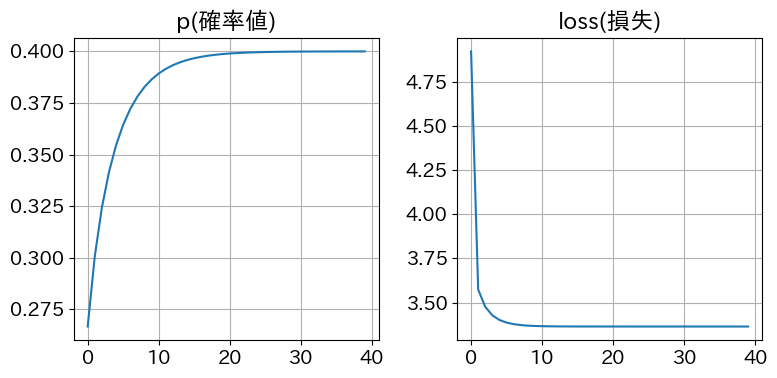

In [7]:
plt.rcParams['figure.figsize'] = (8, 4)
fig, axes = plt.subplots(1, 2)
axes[0].plot(logs[:,0], logs[:,1])
axes[0].set_title('p(確率値)')
axes[1].plot(logs[:,0], logs[:,2])
axes[1].set_title('loss(損失)')
plt.tight_layout();

### 4.3 ベイズ推論(確率モデル定義)

#### データ(観測値)準備

In [8]:
X = np.array([1, 0, 0, 1, 0])
print(X)

[1 0 0 1 0]


#### 確率モデル定義

In [9]:
# コンテキスト定義
model1 = pm.Model()

with model1:
    # pm.Uniform: 一様分布
    p = pm.Uniform('p', lower=0.0, upper=1.0)

    # pm.Bernoulli: ベルヌーイ分布
    X_obs = pm.Bernoulli('X_obs', p=p, observed=X)

#### 確率モデルの可視化

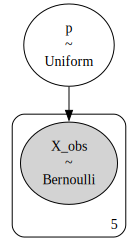

In [10]:
g = pm.model_to_graphviz(model1)
display(g)

### 4.4 ベイズ推論(サンプリング)

#### パラメータ値を明示的に設定してサンプリング

In [11]:
with model1:
    idata1_1 = pm.sample(
        # 乱数系列の数(デフォルト2)
        chains=3,
        # 捨てるサンプル数(デフォルト1000)
        tune=2000,
        # 取得するサンプル数(デフォルト1000)
        draws=2000,
        random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [p]


Sampling 3 chains for 2_000 tune and 2_000 draw iterations (6_000 + 6_000 draws total) took 20 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


#### すべてデフォルト値でサンプリング

In [12]:
with model1:
    idata1_2 = pm.sample(random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


### 4.5 ベイズ推論( 結果分析)

#### plot_trace 関数呼び出し

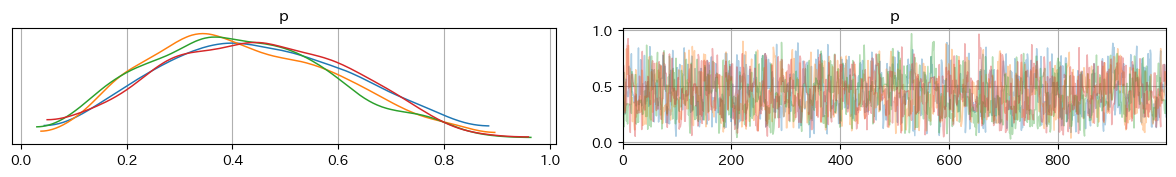

In [13]:
axes = az.plot_trace(idata1_2, compact=False)
plt.tight_layout();

#### plot_posteror関数呼び出し

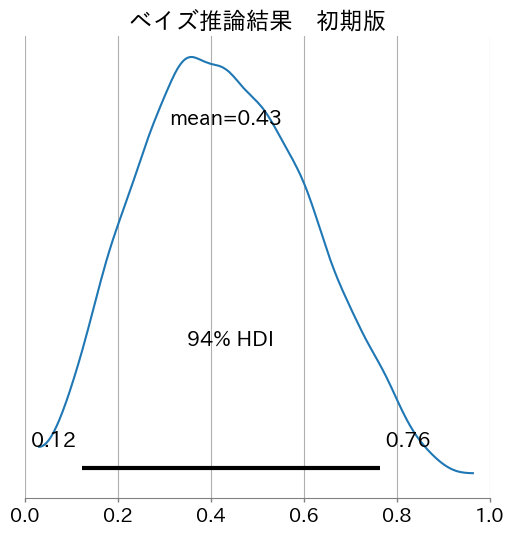

In [14]:
plt.rcParams['figure.figsize'] = (6, 6)
ax = az.plot_posterior(idata1_2)
ax.set_xlim(0, 1)
ax.set_title('ベイズ推論結果　初期版');

#### summary関数呼び出し

In [15]:
summary1_2 = az.summary(idata1_2)
display(summary1_2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.432,0.177,0.123,0.764,0.004,0.003,1662.000,2567.000,1.000


### 4.6 ベイズ推論(二項分布バージョン)

#### 確率モデル定義　二項分布バージョン

In [16]:
# コンテキスト定義
model2 = pm.Model()

with model2:
    # pm.Uniform: 一様分布
    p = pm.Uniform('p', lower=0.0, upper=1.0)

    # pm.Binomial: 二項分布
    # p: 成功確率
    # n: 試行数
    X_obs = pm.Binomial('X_obs', p=p, n=5, observed=2)

####  二項分布バージョンの確率モデル可視化

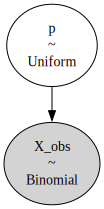

In [17]:
# モデル構造可視化
g = pm.model_to_graphviz(model2)
display(g)

#### サンプリング

In [18]:
with model2:
    idata2 = pm.sample(random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


#### 結果分析

##### plot_trace関数呼び出し

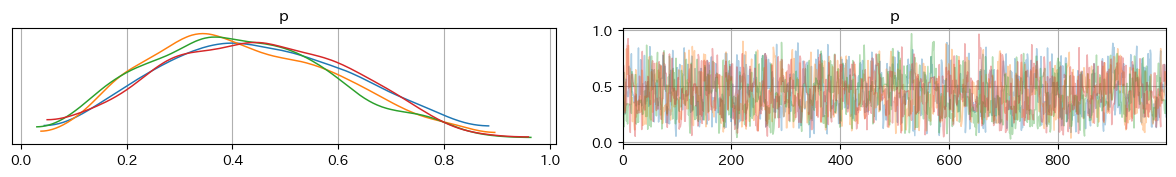

In [19]:
axes = az.plot_trace(idata2, compact=False)
plt.tight_layout();

##### plot_posteror関数呼び出し

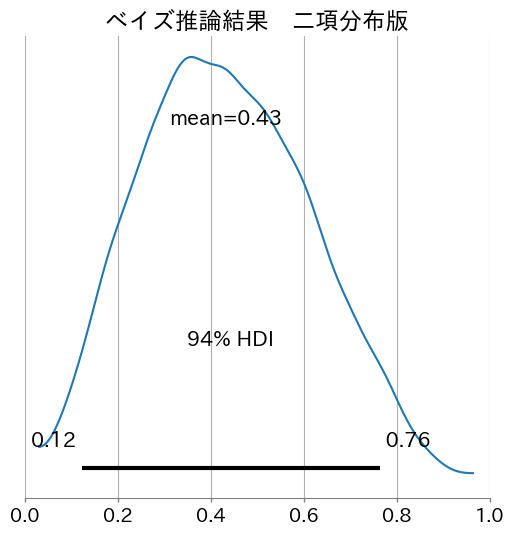

In [20]:
plt.rcParams['figure.figsize'] = (6, 6)
ax = az.plot_posterior(idata2)
ax.set_xlim(0, 1)
ax.set_title('ベイズ推論結果　二項分布版');

##### summary関数呼び出し

In [21]:
summary2 = az.summary(idata2)
display(summary2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.432,0.177,0.123,0.764,0.004,0.003,1662.000,2567.000,1.000


### 4.7 ベイズ推論(試行数を増やす)

#### 確率モデル定義

In [22]:
# コンテキスト定義
model3 = pm.Model()

with model3:
    # pm.Uniform: 一様分布
    p = pm.Uniform('p', lower=0.0, upper=1.0)

    # pm.Binomial:  二項分布
    # p: 成功確率
    # n: 試行数
    X_obs = pm.Binomial('X_obs', p=p, n=50, observed=20)

#### 確率モデル可視化

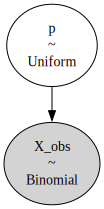

In [23]:
g = pm.model_to_graphviz(model3)
display(g)

#### サンプリング

In [24]:
# サンプリング
with model3:
    idata3 = pm.sample(random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


#### 結果分析

##### plot_trace関数呼び出し

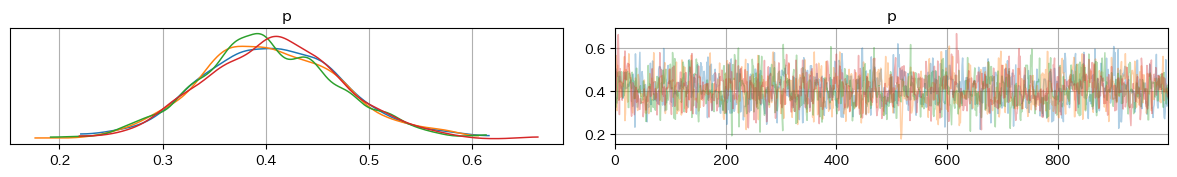

In [25]:
axes = az.plot_trace(idata3, compact=False)
plt.tight_layout();

##### plot_posterior関数呼び出し

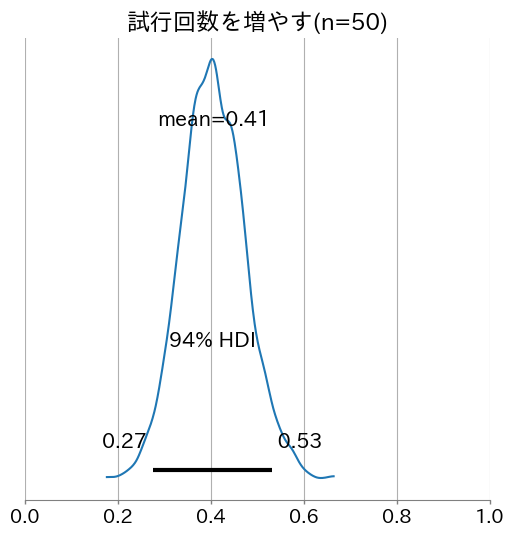

In [26]:
plt.rcParams['figure.figsize'] = (6, 6)
ax = az.plot_posterior(idata3)
ax.set_xlim(0, 1)
ax.set_title('試行回数を増やす(n=50)');

##### summary関数呼び出し

In [27]:
summary3 = az.summary(idata3)
display(summary3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.406,0.068,0.275,0.531,0.002,0.001,1828.000,2909.000,1.000


### 4.8 事前分布を変更する


In [28]:
# コンテキスト定義
model4 = pm.Model()

with model4:
    # 確率モデル定義

    # 一様分布のパラメータを変更
    p = pm.Uniform('p', lower=0.1, upper=0.9)

    # 5回中2回あたりという観測値はそのまま
    X_obs = pm.Binomial('X_obs', p=p, n=5, observed=2)

    # サンプル値取得
    idata4 = pm.sample(random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.433,0.171,0.116,0.728,0.005,0.003,1261.000,1288.000,1.000


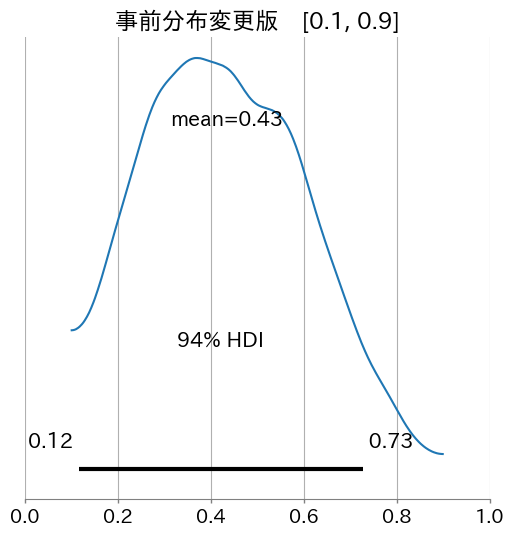

In [29]:
plt.rcParams['figure.figsize'] = (6, 6)
# 事後分布の可視化
ax = az.plot_posterior(idata4)
ax.set_title('事前分布変更版　[0.1, 0.9]')
ax.set_xlim(0, 1)

# サンプル値の集計
summary4 = az.summary(idata4)
display(summary4)

### 4.9 ベータ分布との比較

#### ベータ分布とベイズ推論結果の重ね描き

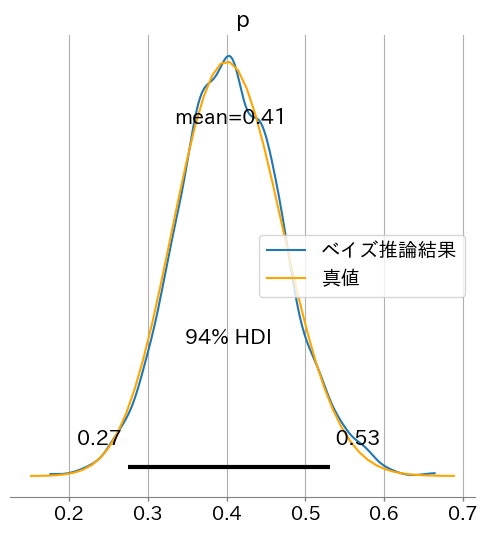

In [30]:
# 真のベータ関数の定義
from scipy import stats
alpha = 20 + 1
beta = 30 + 1
true_beta = stats.beta(alpha, beta)

plt.rcParams['figure.figsize'] = (6, 6)
# ベイズ推論結果の可視化
# idata3は4.7節で計算した結果を利用
ax = az.plot_posterior(idata3)
ax.lines[0].set_label('ベイズ推論結果')

# 真のベータ関数の可視化
x = np.linspace(*ax.get_xlim())
ax.plot(x, true_beta.pdf(x), color='orange', label='真値')
ax.legend(loc='center right');

### コラム ArviZのFAQ

#### plot_posterior関数でyスケールを表示

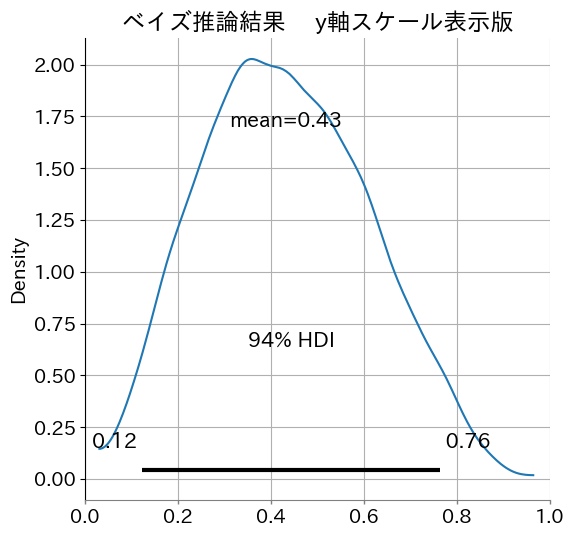

In [31]:
plt.rcParams['figure.figsize'] = (6, 6)
ax = az.plot_posterior(idata1_2)

# y軸の線の表示
ax.spines['left'].set_visible(True)

# y軸ラベル表示
ax.set_ylabel("Density")

# y軸のティックの位置を自動的に決定
from matplotlib.ticker import AutoLocator
ax.yaxis.set_major_locator(AutoLocator())

ax.set_xlim(0, 1)
ax.set_title('ベイズ推論結果　 y軸スケール表示版');

#### plot_trace関数グラフでタイトルを変更

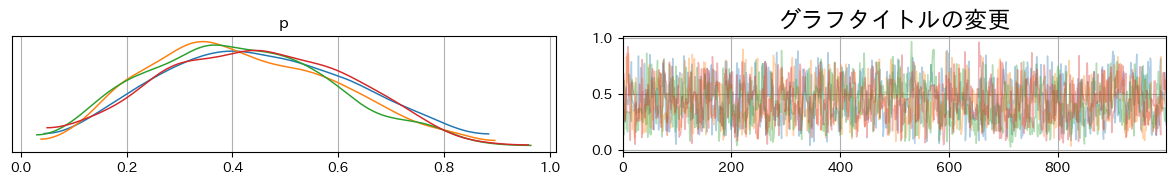

In [32]:
axes = az.plot_trace(idata1_2, compact=False)
plt.tight_layout()
axes[0,1].set_title('グラフタイトルの変更');

#### バージョンの確認

In [33]:
#!pip install watermark | tail -n 1
%load_ext watermark
%watermark --iversions

matplotlib         : 3.8.3
scipy              : 1.12.0
numpy              : 1.26.4
pandas             : 2.2.1
japanize_matplotlib: 1.1.3
pymc               : 5.11.0
torch              : 2.2.1
seaborn            : 0.12.2
arviz              : 0.17.1

